# Import libraries

In [9]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [10]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from scipy import signal

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex, u_diode_data_to_df
from src.modeling.sec_quench import *
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')

# Define Paths

In [11]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / '20220707_data'

# Read the (clean) MP3 file

In [12]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

4763

# Select events to analyze

In [13]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

896 4379


In [33]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged["VoltageNXCALS.*U_DIODE"]==1]

# Analyze all events

In [ ]:
df_results = mp3_fpa_df_period_all[['Circuit Family','Circuit Name','timestamp_fgc','Position']]
time_frame_after_quench = [0, 2]

for k, row in df_to_analyze.iterrows():
    
    circuit_name = row['Circuit Name']
    timestamp_fgc = int(row['timestamp_fgc'])
    fpa_identifier = f"{row['Circuit Family']}_{row['Circuit Name']}_{int(row['timestamp_fgc'])}"
    
    data_dir = data_path / (fpa_identifier + ".hdf5")
    data = load_from_hdf_with_regex(file_path=data_dir, regex_list=["VoltageNXCALS.*U_DIODE"])
    df_data_nxcals = u_diode_data_to_df(data)
    
    df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & (mp3_fpa_df["Circuit Name"] == circuit_name)]
    print(f"{k}/{len(df_to_analyze)} {fpa_identifier} n_quenches:{len(df_subset)} len_data:{len(df_data_nxcals)}")
    
    quench_times = df_subset["Delta_t(iQPS-PIC)"].values /1e3
    sec_quenches = get_sec_quench_frame_exclude_quench(df_data=df_data_nxcals, 
                                     all_quenched_magnets=df_subset.Position.values, 
                                     quench_times=quench_times, 
                                     time_frame=time_frame_after_quench)
    
    for sec_quench_number, df_quench_frame in enumerate(sec_quenches):
        if not df_quench_frame.empty:
            df_results_new = get_sec_quench_features(df_quench_frame=df_quench_frame,
                                                     df_mp3_subset=df_subset,
                                                     time_frame_after_quench=time_frame_after_quench,
                                                     sec_quench_number=sec_quench_number)
            df_results = pd.concat([df_results, df_results_new])

df_results.dropna().to_csv("../data/sec_quench_feature.csv")

In [30]:
df_results= pd.read_csv("../data/sec_quench_feature.csv").drop(columns="Unnamed: 0")
df_results

,Circuit Family,Circuit Name,timestamp_fgc,Position,sec_quench_number,start_time,min_time,max_time,min_amplitude,max_amplitude,...,n_other_quenches,dstd_score_pos_15,dstd_score_elpos_15,dstd_score_pos_15_exp,dstd_score_elpos_15_exp,dstd_score_pos_15_tuk,dstd_score_elpos_15_tuk,wiggle_magnets,wiggle_area_pos,wiggle_area_elpos
0,RB,RB.A12,1.418485e+18,B27R1,0,43.821,0.098,1.886,0.031043,0.015857,...,0,1.074654,1.059131,1.065443,0.984642,1.083474,1.051108,0,12,11
1,RB,RB.A12,1.418485e+18,C27R1,1,88.105,0.115,1.800,0.017942,0.026084,...,0,1.014666,0.996087,1.004114,1.008033,1.005196,1.009296,0,52,22
2,RB,RB.A12,1.418485e+18,C26R1,2,152.906,0.200,1.113,0.011153,0.026012,...,0,1.005526,0.953407,1.019010,0.894357,0.991250,0.941392,7,50,8
3,RB,RB.A12,1.418539e+18,B29R1,0,70.999,1.183,1.100,0.052397,0.063614,...,1,0.921736,1.173468,0.915016,1.312289,0.917122,1.229905,12,8,18
4,RB,RB.A12,1.418539e+18,A30R1,1,71.999,0.183,1.886,0.052397,0.025522,...,0,0.922943,1.215764,0.893334,1.375066,0.907880,1.260214,7,8,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3363,RB,RB.A81,1.657110e+18,C33L1,1,70.742,0.000,1.898,0.021992,0.014277,...,0,1.033068,1.075941,1.371316,0.992267,1.165355,1.130798,3,12,12
3364,RB,RB.A81,1.657110e+18,C32L1,2,77.642,0.100,1.900,0.017193,0.011049,...,0,0.953908,0.944755,0.941486,0.904874,0.960398,0.926540,6,10,8
3365,RB,RB.A81,1.657110e+18,B32L1,3,126.540,0.201,1.898,0.007275,0.006678,...,0,0.972609,1.043967,0.975474,1.096525,0.959547,1.062249,6,13,15
3366,RB,RB.A81,1.657110e+18,A34L1,4,283.936,0.804,0.000,0.001476,0.002585,...,1,1.008132,1.004420,0.979977,1.022503,1.000512,1.013548,6,12,15


In [31]:
df_results_old= pd.read_csv("sec_quench_features.csv").drop(columns="Unnamed: 0")
df_results_old

,Circuit Family,Circuit Name,timestamp_fgc,Position,sec_quench_number,start_time,min_time,max_time,min_amplitude,max_amplitude,...,n_other_quenches,dstd_score_pos_15,dstd_score_elpos_15,dstd_score_pos_15_exp,dstd_score_elpos_15_exp,dstd_score_pos_15_tuk,dstd_score_elpos_15_tuk,wiggle_magnets,wiggle_area_pos,wiggle_area_elpos
0,RB,RB.A12,1.418485e+18,B27R1,0.0,43.821,0.098,1.886,0.031043,0.015857,...,0.0,1.074654,1.059131,1.065443,0.984642,1.083474,1.051108,0.0,12.0,11.0
1,RB,RB.A12,1.418485e+18,C27R1,1.0,88.105,0.115,1.800,0.017942,0.026084,...,0.0,1.014666,0.996087,1.004114,1.008033,1.005196,1.009296,0.0,52.0,22.0
2,RB,RB.A12,1.418485e+18,C26R1,2.0,152.906,0.200,1.113,0.011153,0.026012,...,0.0,1.005526,0.953407,1.019010,0.894357,0.991250,0.941392,7.0,50.0,8.0
3,RB,RB.A12,1.418539e+18,B29R1,0.0,70.999,1.183,1.100,0.052397,0.063614,...,1.0,0.921736,1.173468,0.915016,1.312289,0.917122,1.229905,12.0,8.0,18.0
4,RB,RB.A12,1.418539e+18,A30R1,1.0,71.999,0.183,1.886,0.052397,0.025522,...,0.0,0.922943,1.215764,0.893334,1.375066,0.907880,1.260214,7.0,8.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,RB,RB.A81,1.657110e+18,C33L1,1.0,70.742,0.000,1.898,0.021992,0.014277,...,0.0,1.033068,1.075941,1.371316,0.992267,1.165355,1.130798,3.0,12.0,12.0
3287,RB,RB.A81,1.657110e+18,C32L1,2.0,77.642,0.100,1.900,0.017193,0.011049,...,0.0,0.953908,0.944755,0.941486,0.904874,0.960398,0.926540,6.0,10.0,8.0
3288,RB,RB.A81,1.657110e+18,B32L1,3.0,126.540,0.201,1.898,0.007275,0.006678,...,0.0,0.972609,1.043967,0.975474,1.096525,0.959547,1.062249,6.0,13.0,15.0
3289,RB,RB.A81,1.657110e+18,A34L1,4.0,283.936,0.804,0.000,0.001476,0.002585,...,1.0,1.008132,1.004420,0.979977,1.022503,1.000512,1.013548,6.0,12.0,15.0


# Read results define plotting function

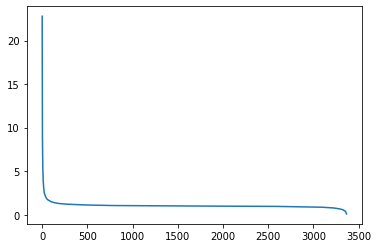

In [22]:
df_results= pd.read_csv("../data/sec_quench_feature.csv").drop(columns="Unnamed: 0")
df_results = df_results.sort_values(by='dstd_score_pos_15', ascending=False).reset_index(drop=True)
df_results = df_results.merge(df_acquisition, left_on=["Circuit Name", 'timestamp_fgc'], right_on=["Circuit Name", 'timestamp_fgc'], how="left") 

df_results.dstd_score_pos_15.plot(legend=False)


features = ['min_time', 'max_time', 'min_amplitude', 'max_amplitude', "dU_min", "dU_max", "dstd_max",  'dstd_score_pos_15', 'dstd_score_elpos_15', 'dstd_score_pos_15_exp', 
           'dstd_score_elpos_15_exp','dstd_score_pos_15_tuk', 'dstd_score_elpos_15_tuk', 'wiggle_area_pos','wiggle_area_elpos', "el_peak12_ratio", "n_other_quenches","wiggle_magnets"]

features = ['dstd_score_pos_15', 'dstd_score_elpos_15', 'dstd_score_pos_15_exp', "el_peak12_ratio", "n_other_quenches","wiggle_magnets"]
#features = ["dstd_score_pos_15_tuk", "dstd_score_elpos_15_tuk", "start_time", "dstd_max", "n_other_quenches", "el_peak12_ratio", "wiggle_magnets"]

# Type 1 oscillation, propagation only electrically

In [36]:
sort_feature = 'dstd_score_elpos_15'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 2

# define manual thresholds to find type 1
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["start_time"]>=0.5]
df_plot = df_plot[df_plot["dstd_max"]>=0.05]
df_plot = df_plot[df_plot["n_other_quenches"]<1]
df_plot = df_plot[df_plot["el_peak12_ratio"]>=2]
df_plot = df_plot[df_plot["wiggle_magnets"]>1]

print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

KeyError: 'VoltageNXCALS.*U_DIODE'

# Type 2 Oscillation that propagates physically and electrically

508


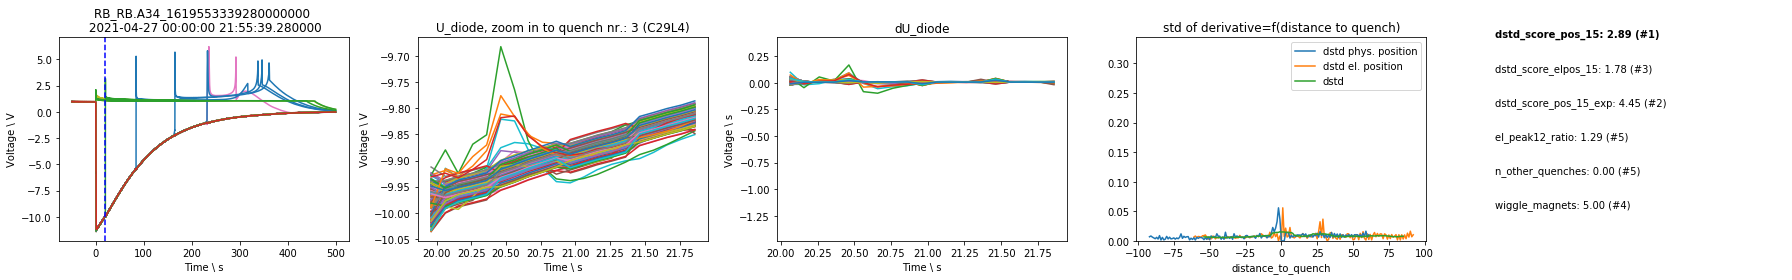

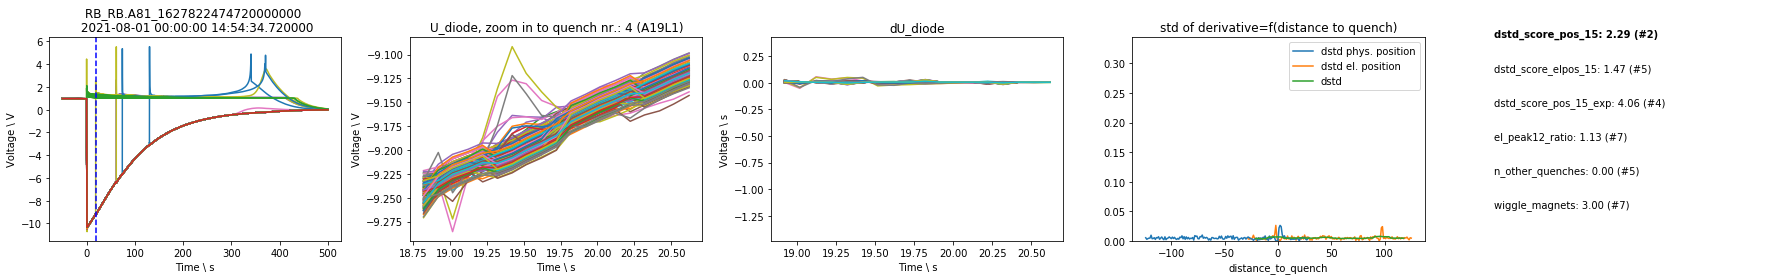

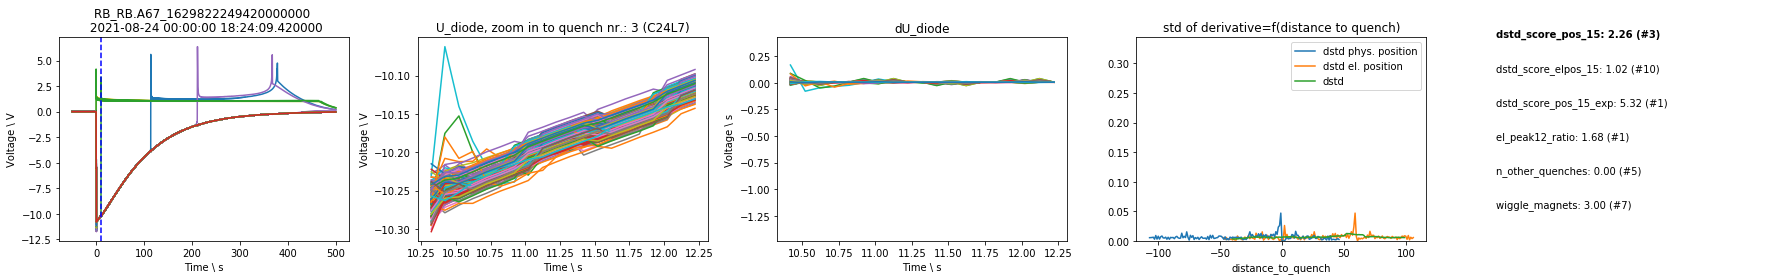

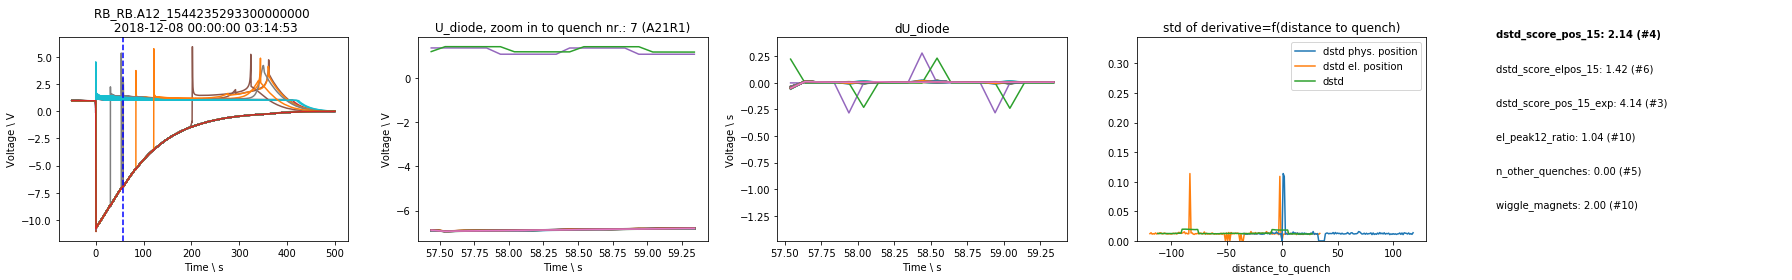

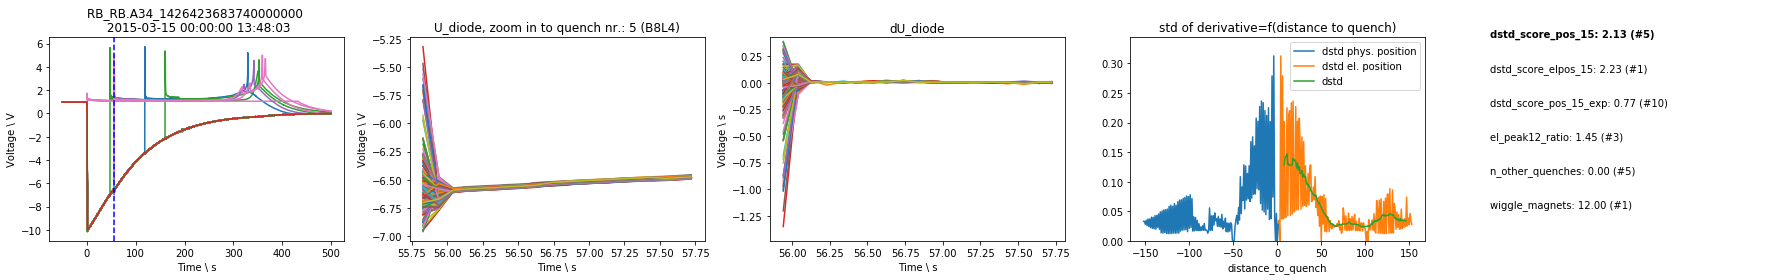

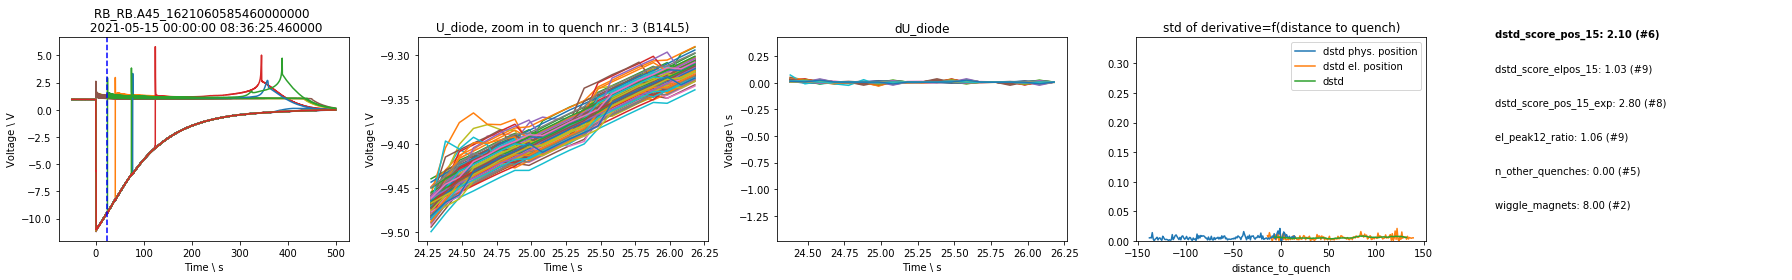

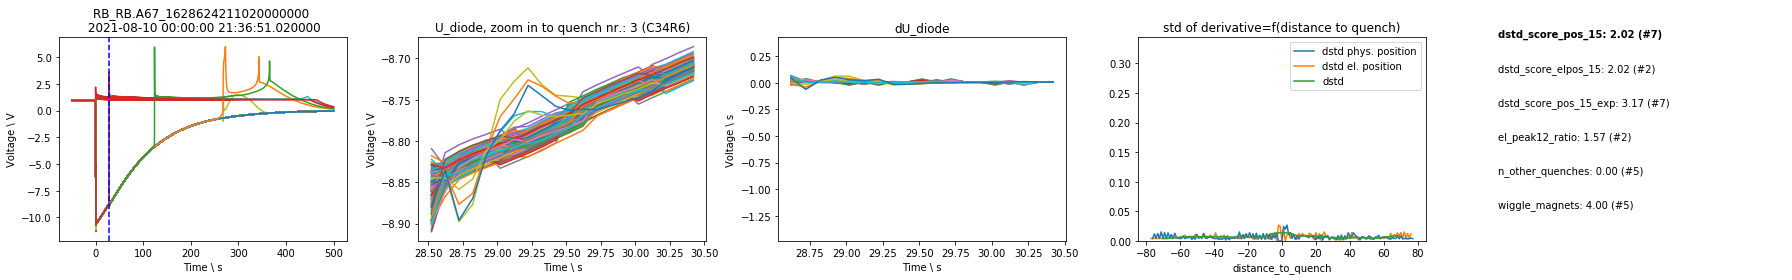

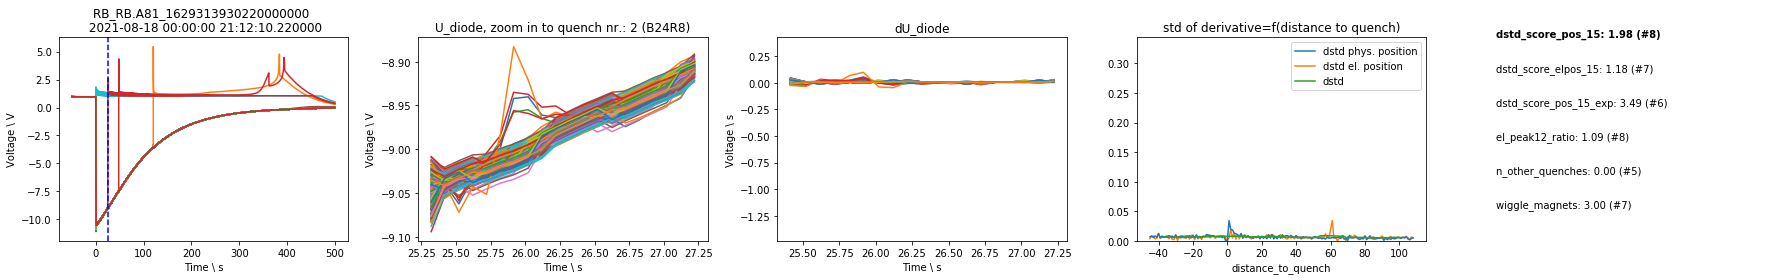

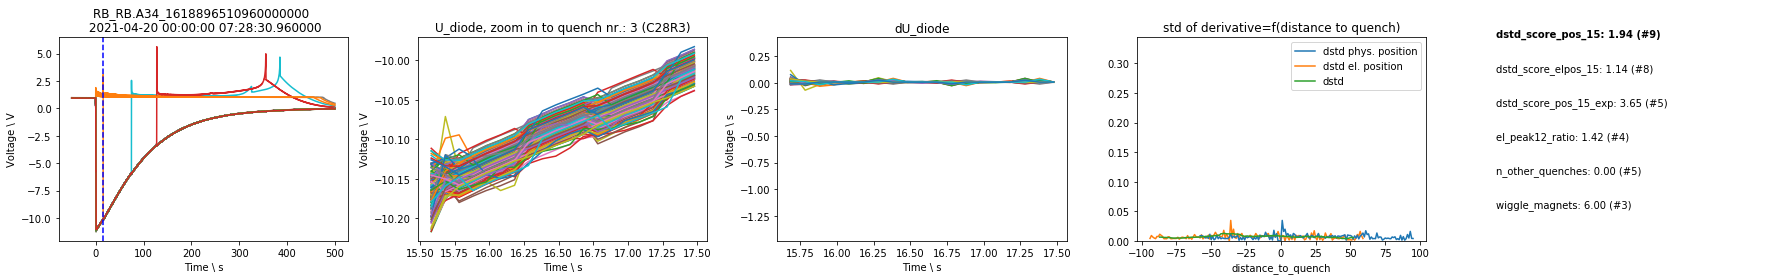

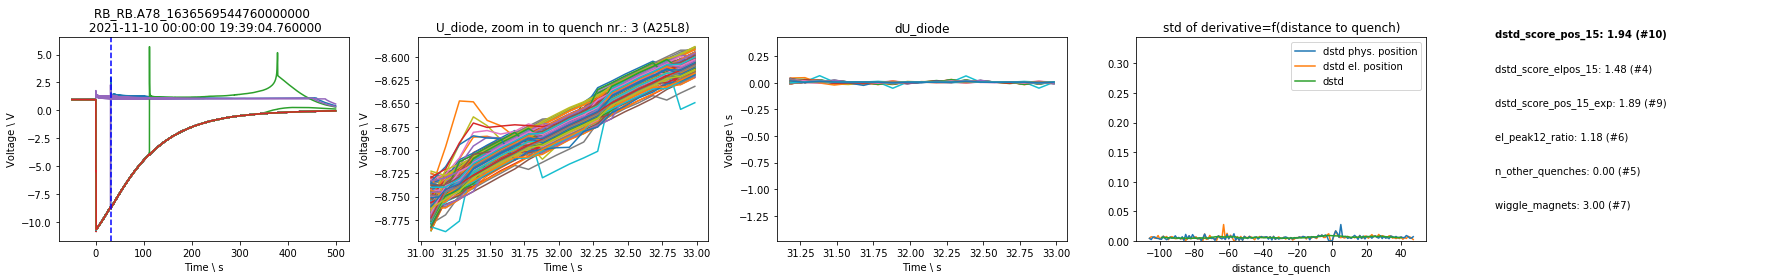

In [35]:
sort_feature = 'dstd_score_pos_15'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 10

# Filter
#df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["start_time"]>=10]
df_plot = df_plot[df_plot["dstd_max"]>=0.02]
df_plot = df_plot[df_plot["el_peak12_ratio"]<2]
df_plot = df_plot[df_plot["n_other_quenches"]<1]
df_plot = df_plot[df_plot["wiggle_magnets"]>1]

print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Type 3 Oscillation in only one magnet 

358


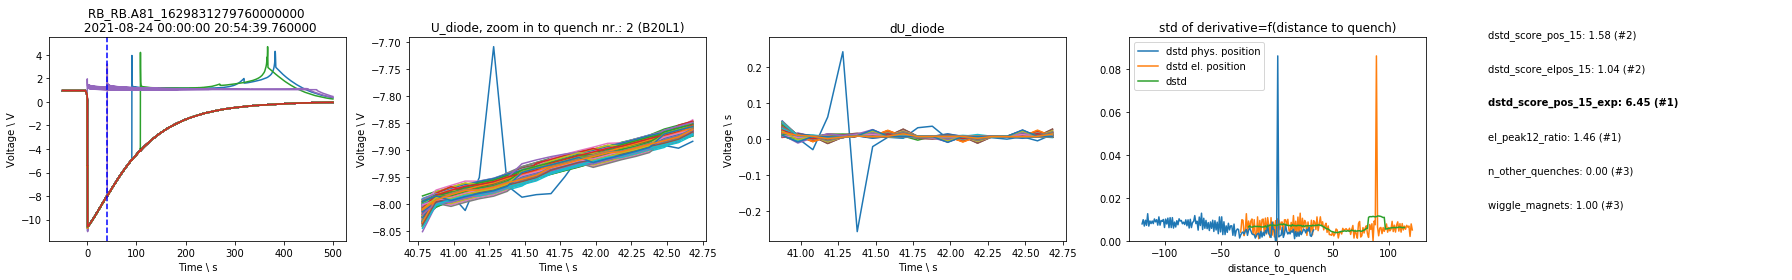

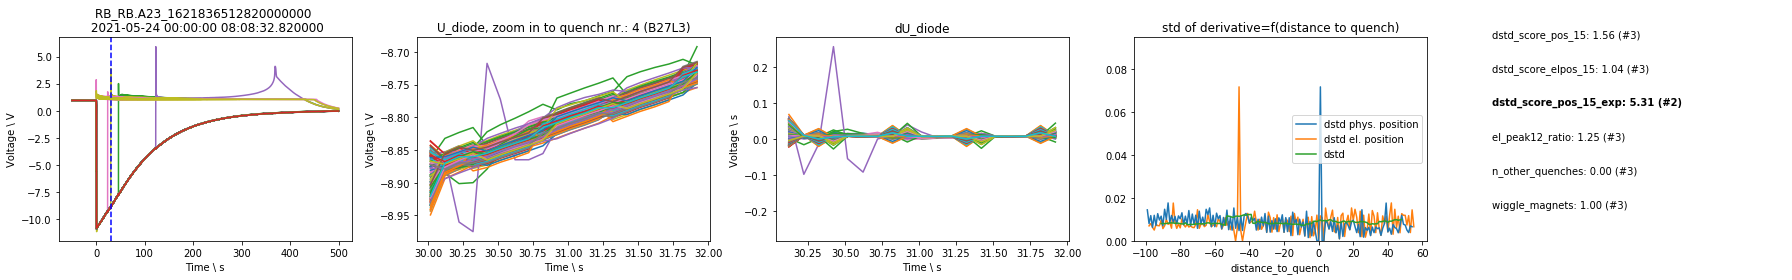

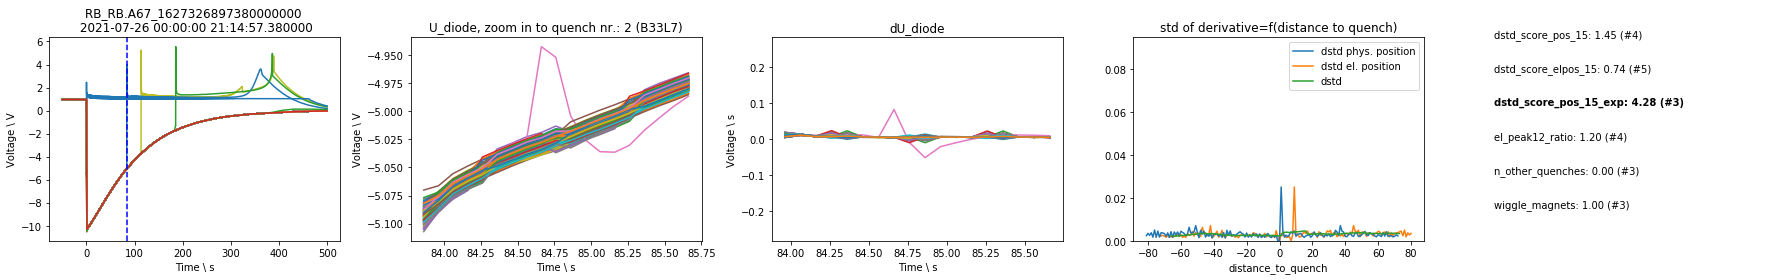

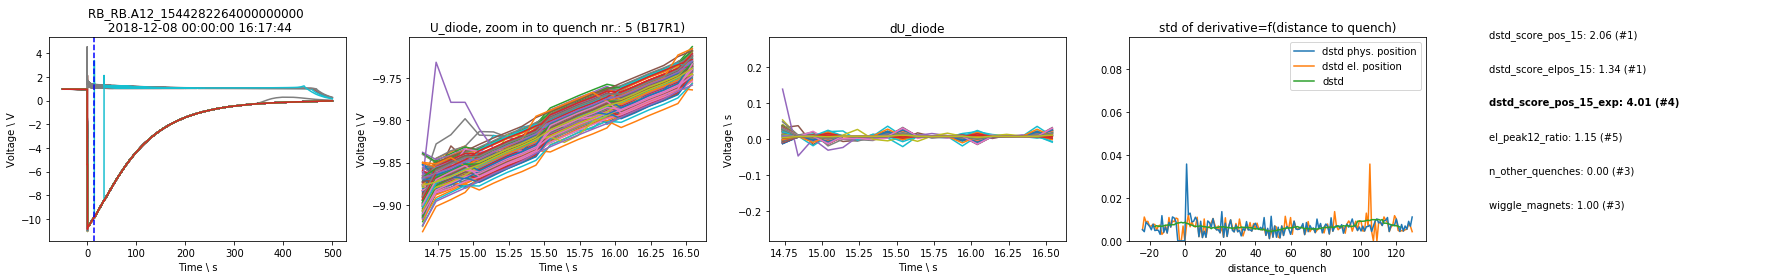

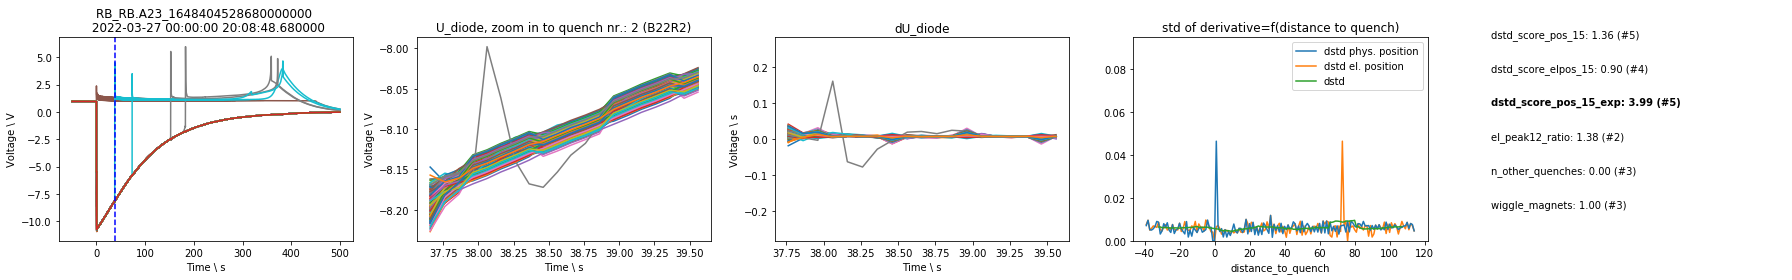

In [25]:
sort_feature = 'dstd_score_pos_15_exp'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 5

# Filter
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["start_time"]>=0.5]
df_plot = df_plot[df_plot["el_peak12_ratio"]<2]
df_plot = df_plot[df_plot["n_other_quenches"]<1]
df_plot = df_plot[df_plot["wiggle_magnets"]==1]
print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Type 3 Oscillation due to another quench in time window

93


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



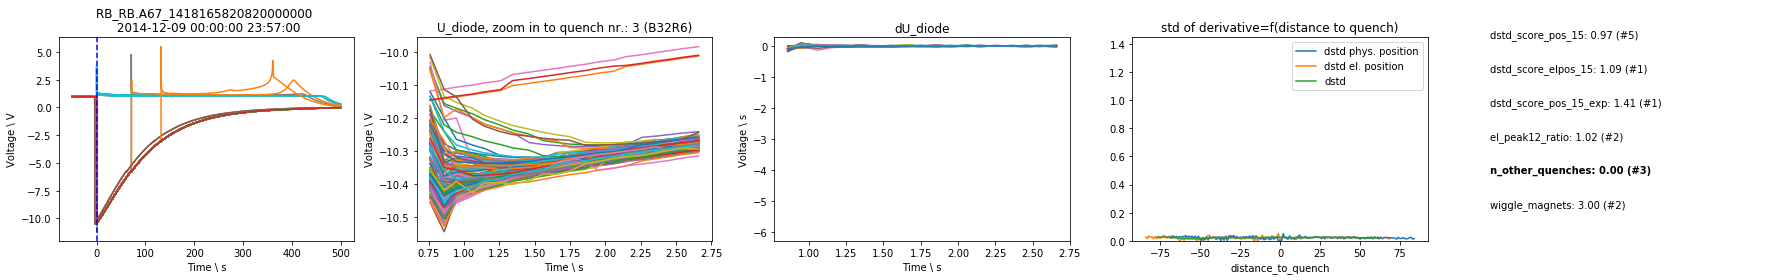

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Error in callback <function flush_figures at 0x7f1d5889ed30> (for post_execute):
Traceback (most recent call last):
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/IPython/core/events.py", line 88, in trigger
    func(*args, **kwargs)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py", line 117, in flush_figures
    return show(True)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py", line 37, in show
    display(
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/IPython/core/display.py", line 304, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/IPython/core/formatter

KeyboardInterrupt: 

In [26]:
sort_feature = 'n_other_quenches'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 5
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["start_time"]>=0.5]
df_plot = df_plot[df_plot["dstd_max"]>0.05]
df_plot = df_plot[df_plot["el_peak12_ratio"]<=1.5]
print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Type 4 Oscillation due to acquisition

In [ ]:
sort_feature = 'dstd_score_pos_15'
df_plot = df_results.sort_values(by=sort_feature, ascending=False).reset_index(drop=True)

show_n_quenches = 5
df_plot = df_plot[df_plot["VoltageNXCALS.*U_DIODE"]==1]
df_plot = df_plot[df_plot["dstd_max"]<0.02]
df_plot = df_plot[df_plot["start_time"]>=0.5]
df_plot = df_plot[df_plot["el_peak12_ratio"]<2]
df_plot = df_plot[df_plot["n_other_quenches"]<1]
print(len(df_plot))

plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_plot,
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)

# Other analysis

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [ ]:
scaler = StandardScaler()
df_tsne = df_results.copy()

# Filter
#df_tsne = df_tsne[df_tsne["start_time"]>=0.5]
#df_tsne = df_tsne[df_tsne["dstd_max"]>=0.02]
#df_tsne = df_tsne[df_tsne["n_other_quenches"]<1]
print(len(df_tsne))

df_tsne[features] = scaler.fit_transform(df_tsne[features])
X = df_tsne[features].to_numpy(dtype=np.float64)

X_embedded = TSNE(n_components=2, init='random').fit_transform(X)

In [ ]:
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1])

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_embedded)
centers = kmeans.cluster_centers_

center_indices=[]

for i, center in enumerate(centers):
    distance = np.linalg.norm(X_embedded - centers[i:i + 1, :], axis=1)
    center_indices.append(np.argsort(distance)[0])

In [ ]:
plot_wiggle_analysis(
    mp3_fpa_df=mp3_fpa_df,
    df_results=df_tsne.iloc[center_indices],
    data_path=data_path,
    show_n_quenches=show_n_quenches,
    features=features,
    sort_feature=sort_feature)